In [43]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
from matplotlib import pyplot as plt

"""
Start with symmetric system and rank parameters by sensitivity. There is a lot of them!
"""


def hill_act(X, K, n):
    return X**n/(K**n + X**n)
def hill_inh(X, K, n):
    return K**n/(K**n + X**n)

def rhs(xyz, t, params):
    x, y1, y2, z1, z2 = xyz

    dx_dt = params['a'] - params['b'] * x
    dy1_dt = params['c'] * hill_act(x, params['KMxy1'], params['nx']) - params['d'] * y1
    dy2_dt = params['e'] * hill_act(x, params['KMxy2'], params['nx']) - params['f'] * y2
    dz1_dt = params['g'] * hill_act(x, params['KM1x'], params['n1x']) * hill_inh(y1, params['KM1y'], params['n1y']) - params['i'] * z1 + params['h'] * hill_act(z1, params['KM11'], params['n11']) * hill_inh(z2, params['KM12'], params['n12'])
    dz2_dt = params['j'] * hill_act(x, params['KM2x'], params['n2x']) * hill_inh(y2, params['KM2y'], params['n2y']) - params['l'] * z2 + params['k'] * hill_act(z2, params['KM22'], params['n22']) * hill_inh(z1, params['KM21'], params['n21'])
    
    return np.array([dx_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt])

# Define parameter values

# Initial conditions
initial_conditions = [0.0, 0.0, 0.0, 0.0, 0.0]

# Time points for integration
t_span = (0, 100)
t = np.linspace(t_span[0], t_span[1], 101)
params = {
    'a': 1.0, 'b': 1.0, 'c': 10.0, 'd': 1.0, 'e': 10.0, 'f': 1.0, 'g': 10.0, 'h': 10.0, 'i': 0.5, 'j': 10.0,
    'k': 10.0, 'l': 0.5, 'KMxy1': 10.0, 'KMxy2': 10.0, 'KM11': 10.0, 'KM12': 1.0, 'KM1x': 10.0, 'KM1y': 5.0, 
    'KM22': 10.0, 'KM21': 1.0, 'KM2x': 10.0, 'KM2y': 5.0, 'nx': 2, 'n11': 2, 'n12': 2, 'n1x': 2, 'n1y': 2, 
    'n22': 2, 'n21': 2, 'n2x': 2, 'n2y': 2
}
# Integrate the ODEs
perturbation = 0
solution = odeint(rhs, initial_conditions, t, args=(params,))

# Extract the solution for z1 and z2
z1_solution = solution[:,3]
z2_solution = solution[:,4]

initial_conditions = solution[-1,:]

# Perform sensitivity analysis using finite differences
sensitivity_eps = 0.1
sensitivity_matrix = np.zeros((len(z1_solution), len(params)))

for i, param_name in enumerate(params):
    perturbed_params = params.copy()
    perturbed_params[param_name] += perturbed_params[param_name]*sensitivity_eps

    perturbed_solution = odeint(rhs, initial_conditions, t, args=(perturbed_params,))
    perturbed_z1_solution = perturbed_solution[:,3]
    perturbed_z2_solution = perturbed_solution[:,4]

    sensitivity_matrix[:, i] = (abs(perturbed_z1_solution - z1_solution) + abs(perturbed_z2_solution - z2_solution)) / (2 * sensitivity_eps)

# Print or analyze the sensitivity results
print("Sensitivity Matrix:")
print(np.unravel_index(np.argmax(sensitivity_matrix), sensitivity_matrix.shape))
ordered_keys = np.argsort(sensitivity_matrix[-1,:])
print(ordered_keys)

Sensitivity Matrix:
(0, 0)
[21 17  3  5  2  4 13 12 30 26 19 15 28 24 22 10  7 14 18 27 23  8 11  6
  9 16 20  1 25 29  0]


<Figure size 640x480 with 0 Axes>

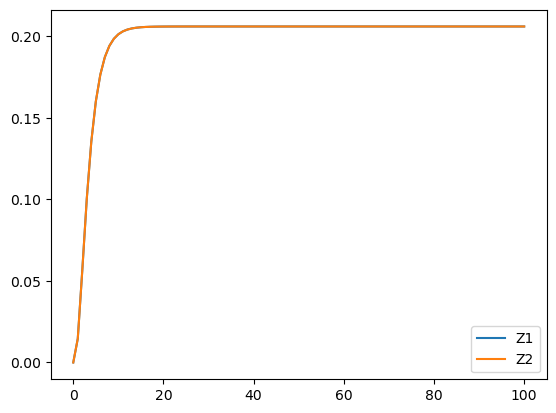

<Figure size 640x480 with 0 Axes>

In [44]:
plt.plot(t, z1_solution)
plt.plot(t, z2_solution)
plt.legend(['Z1', 'Z2'])
plt.figure()

New Dictionary:
KM2y
KM1y
deg_Y1
deg_Y2
prod_Y1
prod_Y2
KMxy2
KMxy1
n2y
n1y
KM21
KM12
n21
n12
nx
act_Z2
act_Z1
KM11
KM22
n22
n11
deg_Z1
deg_Z2
XY_induce_Z1
XY_induce_Z2
KM1x
KM2x
deg_X
n1x
n2x
prod_X
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]
2.060870249010188


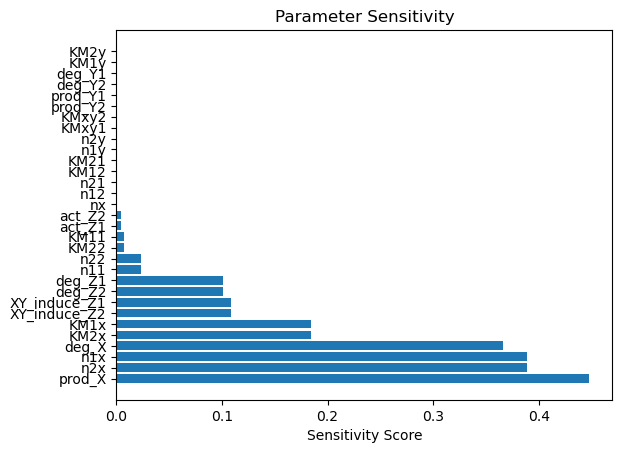

In [45]:
params = {
    'prod_X': 2.0, 'deg_X': 1.0, 'prod_Y1': 10.0, 'deg_Y1': 1.0, 'prod_Y2': 10.0, 'deg_Y2': 1.0, 
    'XY_induce_Z1': 10.0, 'act_Z1': 10.0, 'deg_Z1': 0.5, 'XY_induce_Z2': 10.0,
    'act_Z2': 10.0, 'deg_Z2': 0.5, 'KMxy1': 10.0, 'KMxy2': 10.0, 'KM11': 10.0, 'KM12': 1.0, 'KM1x': 10.0, 'KM1y': 5.0, 
    'KM22': 10.0, 'KM21': 1.0, 'KM2x': 10.0, 'KM2y': 5.0, 'nx': 2, 'n11': 2, 'n12': 2, 'n1x': 2, 'n1y': 2, 
    'n22': 2, 'n21': 2, 'n2x': 2, 'n2y': 2
}
reference = {i: key for i, key in enumerate(params)}
x_labels = []
print("New Dictionary:")
for key in ordered_keys:
    print(reference[key])
    x_labels.append(reference[key])
    
fig, ax = plt.subplots()
# Example data
y_pos = np.arange(len(reference))
print(np.amax(sensitivity_matrix))
ax.barh(y_pos, np.sort(sensitivity_matrix[-1,:]), align='center')
ax.set_yticks(y_pos, labels=x_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sensitivity Score')
ax.set_title('Parameter Sensitivity')

plt.show()

In [74]:
# import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

"""
Perturb parameter pairs and then eventually compare parameters vs slope of dx_dt (with the parameter a)
"""


def hill_act(X, K, n):
    return X**n/(K**n + X**n)
def hill_inh(X, K, n):
    return K**n/(K**n + X**n)

def rhs(xyz, t, a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    x, y1, y2, z1, z2 = xyz

    dx_dt = a - b * x
    dy1_dt = c * hill_act(x, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(x, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(x, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(x, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)
    
    return np.array([dx_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt])

def calc(a, b):
    """
    Brute Force Monte Carlo Parameter Sensitivity Analysis
    """
    # Time points we want for the solution
    t = np.linspace(0, 10, 1000)
   
    # Initial condition
    xyz_0 = np.array([2.0, 2.0, 2.0, 0.0, 0.0])

    # Parameters
    b, c, d, e, f, g, h, i, j, k, l = [0.5, 10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.5, b, 10.0, 0.5]
    nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2, 2, 2, 2, 2, 2, 2, 2, 2]
    KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = [10.0, 10.0, 10.0, 10.0, 10.0, 5.0, 10.0, 2.5, 10.0, 10.0]


    # Integrate ODES
    xyz = integrate.odeint(rhs, xyz_0, t, args=(a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y))
    x, y1, y2, z1, z2 = xyz.transpose()
    return z1[-1], z2[-1]

y1array=np.linspace(0.1,20,100)
y2array=np.linspace(0.1,20,100)
z1xarray=np.empty((100,100))
z2yarray=np.empty((100,100))

for i,R1 in enumerate(y1array):
    for j,R2 in enumerate(y2array):
        values = calc(a=R1, b=R2)
        z1xarray[i,j]=values[0]
        z2yarray[i,j]=values[1]

Z=z1xarray-z2yarray
# Z[Z<-1] = -1
# Z[Z>1] = 1

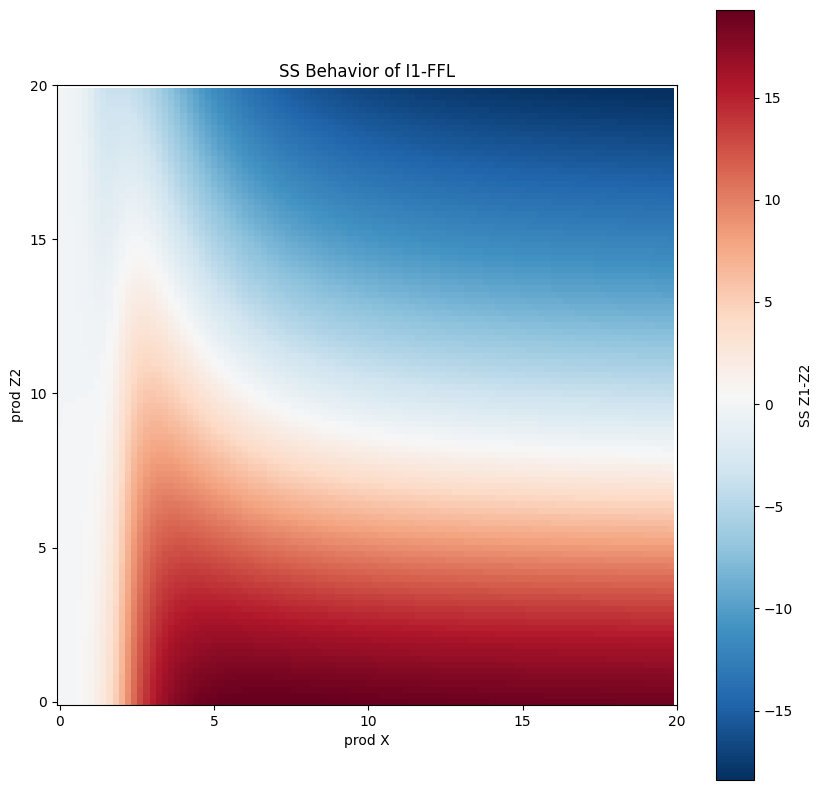

In [75]:
x_ticks = [0, 5, 10, 15, 20]
y_ticks = [0, 0.25, 0.5, 0.75, 1.0]
fig, axs = plt.subplots(figsize=(10, 10))
pc = axs.imshow(Z.T, origin='lower', cmap='RdBu_r')#, vmin=-5, vmax=5)
axs.set_xticks([0, 25, 50, 75, 100], labels=x_ticks)
axs.set_yticks([0, 25, 50, 75, 100], labels=x_ticks)
axs.set_xlabel('prod X')
axs.set_ylabel('prod Z2')
cbar = fig.colorbar(pc)
cbar.set_label('SS Z1-Z2')
axs.set_title(f'SS Behavior of I1-FFL')
plt.show()

In [76]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

"""
The same thing as above but with 2 nested FFLs instead.
"""

sns.set_style('ticks')
%matplotlib inline

# Time points we want for the solution
t = np.linspace(0, 100, 1000)

# Initial condition
xyz_0 = np.array([2.0, 2.0, 2.0, 0.0, 0.0])

# Parameters
Fs = [2, 9, 16]
b, c, d, e, f, g, h, i, j, k, l = [0.5, 10.0, 1.0, 10.0, 1.0, 10.0, 10.0, 0.5, 12.0, 10.0, 0.5]
nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2, 2, 2, 2, 2, 2, 2, 2, 2]
KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = [10.0, 10.0, 10.0, 10.0, 10.0, 5.0, 10.0, 2.5, 10.0, 10.0]


# Keeping Track of the final values:
xs = []
y1s = []
y2s = []
z1s = []
z2s = []

for F in Fs:
    # Integrate ODES
    xyz = integrate.odeint(rhs, xyz_0, t, args=(F, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y))
    # Pluck out y and z
    x, y1, y2, z1, z2 = xyz.transpose()

    # Append the pre-fold change steady state
    x = np.insert(x, 0, 2.0)
    y1 = np.insert(y1, 0, 1.0)
    y2 = np.insert(y2, 0, 1.0)
    z1 = np.insert(z1, 0, 0.0)
    z2 = np.insert(z2, 0, 0.0)
    xs.append(x)
    y1s.append(y1)
    y2s.append(y2)
    z1s.append(z1)
    z2s.append(z2)
t = np.insert(t, 0, -1.0)

# Generate x
#x = 2.0 + 2.0 * (t > 0.0).astype(dtype=float)
# Plot the results
fig, ax = plt.subplots(5, 1, figsize=(8, 8))
for y in y1s:
    ax[1].set_title('Y1')
    ax[1].plot(t, y, '-')
for y in y2s:
    ax[2].set_title('Y2')
    ax[2].plot(t, y, '-')
for x in xs:
    ax[0].set_title('X')
    ax[0].plot(t, x, '-')
for z1 in z1s:
    ax[3].set_title('Z1')
    ax[3].plot(t, z1, '-')
    print(f'Z1 = {z1[-1]}')
for z2 in z2s:
    ax[4].set_title('Z2')
    ax[4].plot(t, z2, '-')
    print(f'Z2 = {z2[-1]}')
for i in range(ax.size):
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])
    ax[i].margins(0.02)
    ax[i].set_xlabel('time', x=.9, fontsize=14)
    ax[i].legend(Fs)
    ax[i].yaxis.set_label_coords(-0.05, 0.9) 
sns.despine(offset=0.1)

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

"""
Perturb parameter pairs and then eventually compare parameters vs slope of dx_dt (with the parameter a)
"""


def hill_act(X, K, n):
    return X**n/(K**n + X**n)
def hill_inh(X, K, n):
    return K**n/(K**n + X**n)

def rhs(xyz, t, a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    x, y1, y2, z1, z2 = xyz

    dx_dt = a - b * x
    dy1_dt = c * hill_act(x, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(x, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(x, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(x, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)
    
    return np.array([dx_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt])

def calc(a, z1_0, z2_0):
    """
    Brute Force Monte Carlo Parameter Sensitivity Analysis
    """
    # Time points we want for the solution
    t = np.linspace(0, 10, 1000)
   
    # Initial condition
    xyz_0 = np.array([2.0, 2.0, 2.0, z1_0, z2_0])

    # Parameters
    b, c, d, e, f, g, h, i, j, k, l = [0.5, 10.0, 1.0, 10.0, 1.0, 10, 10.0, 0.5, 10, 10.0, 0.5]
    nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2, 2, 2, 2, 2, 2, 2, 2, 2]
    KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = [10.0, 10.0, 10.0, 10.0, 10.0, 5.0, 10.0, 2.5, 10.0, 10.0]


    # Integrate ODES
    xyz = integrate.odeint(rhs, xyz_0, t, args=(a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y))
    x, y1, y2, z1, z2 = xyz.transpose()
    return z1[-1], z2[-1]

y1array=np.linspace(0.1,20,100)
y2array=np.linspace(0.1,20,100)
a_array = np.array([2, 9, 15])
z1xarray=np.empty((len(y2array),len(y1array), len(a_array)))
z2yarray=np.empty((len(y2array),len(y1array), len(a_array)))

for k,alpha in enumerate(a_array):
    for i,R1 in enumerate(y1array):
        for j,R2 in enumerate(y2array):
            values = calc(a=alpha, z1_0=R1, z2_0=R2)
            z1xarray[j,i,k]=values[0]
            z2yarray[j,i,k]=values[1]

In [ ]:
for k in range(z1xarray.shape[2]):
    plt.scatter(z1xarray[:,:,k], z2yarray[:,:,k])
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.legend(a_array)

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import odeint
import time

# Gradient descent like function to optimize our parameters
# We can also explore genetic algorithms (these take a long time)
"""
This is a block comment
"""

def hill_act(X, K, n):
    return X**n / (K**n + X**n)

def hill_inh(X, K, n):
    return K**n / (K**n + X**n)

def rhs(xyz, t, a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    x, y1, y2, z1, z2 = xyz

    dx_dt = a - b * x
    dy1_dt = c * hill_act(x, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(x, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(x, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(x, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)

    return np.array([dx_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt])

# Target function to minimize
def ode(params):
    Fs = np.arange(0, 19, 1)
    obj = 0
    for a in Fs:
        b, c, d, e, f, g, h, i, j, k, l = params[:11]
        KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = params[11:]
        # We don't necessarily have to adjust these.
        nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2]*9
#         b, c, d, e, f, g, h, i, j, k, l = [0.5, 10.0, params[0], 10.0, params[1], 10.0, 10.0, params[2], 10.0, 10.0, params[3]]
#         nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2, 2, 2, 2, 2, 2, 2, 2, 2]
#         KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = [10.0, 10.0, 10.0, params[8], params[6], 
#                                                                         params[4], 10.0, params[9], params[7], params[5]]
        # Time points and initial conditions
        t = np.linspace(0, 10, 100)
        initial_conditions = [0, 0, 0, 0, 0]  # Adjust initial conditions as needed, try system starts at 0s

        # Solve ODEs
        solution = odeint(rhs, initial_conditions, t, args=(a, b, c, d, e, f, g, h, i, j, k, l,
                                                            KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
                                                            KM22, KM21, KM2x, KM2y, nx, n11, n12,
                                                            n1x, n1y, n22, n21, n2x, n2y))

        # Calculate the objective values based on steady states of z1 and z2
        steady_state_z1 = solution[-1, 3]
        steady_state_z2 = solution[-1, 4]

        # Minimize negative objectives to achieve the desired behavior
        # fix these objective/cost functions to actually match what we're looking for
        if a < 9:
            obj += abs(steady_state_z1-steady_state_z2) * a * (a-18)
        else:
            obj += abs(steady_state_z2-steady_state_z1) * a * (a-18)
# #         else:
# #             obj += abs(steady_state_z1-steady_state_z2)
        #obj += 1/(steady_state_z1 - steady_state_z2) ** 2
        return obj

# Initial guess for parameters
# Use symmetrical system for initial parameters
degradation_rates = [0,2,4,7,10]

initial_params = 10 * np.random.rand(21) 
#initial_params[degradation_rates] = np.random.rand(len(degradation_rates)) * 2

# Adjust the number of parameters as needed
# Bounds for parameters (adjust as needed)
# Adjust parameter bounds
param_bounds = np.array([(1e-6, 100)] * 21)
param_bounds[degradation_rates] = (1e-6, 0.5)


# initial_params = 100 * np.random.rand(10)
# initial_params[:4] = np.random.rand(4)
# param_bounds = np.array([(0.01, 1)] * 10)
# param_bounds[4:] = (1, 100)

# Perform optimization
start_time = time.time()
result = minimize(ode, initial_params, bounds=param_bounds)

optimized_params = result.x
print("Optimized parameters:", optimized_params)
success = ['unsucessful', 'successful']
print(f'Optimization was {success[result.success]} and took {time.time()-start_time} seconds')

Text(0, 0.5, 'SS FOXA2')

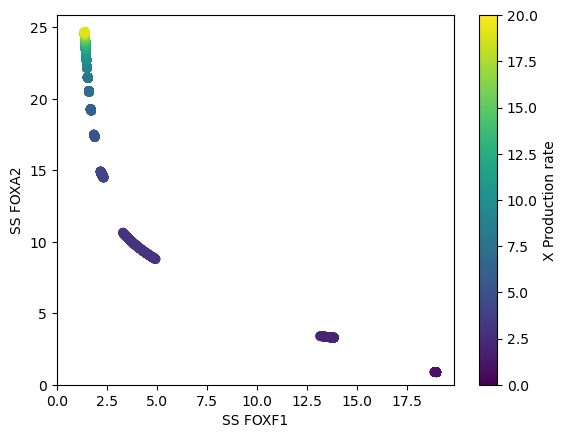

In [53]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import odeint
import time

optimized_params = np.array([0.5,        5.37352557, 0.5,        0.15164532, 0.5,        3.41323608,
 8.08063479, 0.5,        8.07576539, 5.52822741, 0.5,        4.33834965,
 7.0079098,  5.77644675, 5.86557976, 1.17319128, 5.2299828,  9.7703752,
 8.80489012, 8.41532703, 4.81912212])

def hill_act(X, K, n):
    return X**n / (K**n + X**n)

def hill_inh(X, K, n):
    return K**n / (K**n + X**n)

def rhs(xyz, t, a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    x, y1, y2, z1, z2 = xyz

    dx_dt = a - b * x
    dy1_dt = c * hill_act(x, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(x, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(x, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(x, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)

    return np.array([dx_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt])

def calc(a, params, z1_0, z2_0):
    # Time points we want for the solution
    t = np.linspace(0, 20, 1000)


    # Initial condition
    xyz_0 = np.array([2.0, 2.0, 2.0, z1_0, z2_0])

    # Parameters
    b, c, d, e, f, g, h, i, j, k, l = optimized_params[:11]
    KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = optimized_params[11:]
    nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2]*9
    
#     b, c, d, e, f, g, h, i, j, k, l = [0.5, 10.0, optimized_params[0], 10.0, optimized_params[1], 10.0, 
#                                        10.0, optimized_params[2], 10.0, 10.0, optimized_params[3]]
#     nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2, 2, 2, 2, 2, 2, 2, 2, 2]
#     KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = [10.0, 10.0, 10.0, optimized_params[8], optimized_params[6], 
#                                                                     optimized_params[4], 10.0, optimized_params[9], 
#                                                                     optimized_params[7], optimized_params[5]]

    # Integrate ODES
    xyz = odeint(rhs, xyz_0, t, args=(a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y))
    x, y1, y2, z1, z2 = xyz.transpose()
    return z1[-1], z2[-1]

y1array=np.arange(0,20,1)
y2array=np.arange(0,20,1)
a_array = np.array([2, 9, 15])
a_array = np.arange(1, 20, 1)
z1xarray=np.empty((len(y2array),len(y1array), len(a_array)))
z2yarray=np.empty((len(y2array),len(y1array), len(a_array)))

for k,alpha in enumerate(a_array):
    for i,R1 in enumerate(y1array):
        for j,R2 in enumerate(y2array):
            values = calc(a=alpha,params = optimized_params, z1_0=R1, z2_0=R2)
            z1xarray[j,i,k]=values[0]
            z2yarray[j,i,k]=values[1]

fig, axs = plt.subplots()
for k in range(z1xarray.shape[2]):
    #Splt.scatter(z1xarray[:,:,k], z2yarray[:,:,k], label = f'alpha = {a_array[k]}')
    a = plt.scatter(z1xarray[:,:,k], z2yarray[:,:,k], c=a_array[k]*np.ones(len(z1xarray[:,:,k]) ** 2), cmap='viridis', vmin=0, vmax=20)
fig.colorbar(a, label='X Production rate')
axs.set_xlim(0)
axs.set_ylim(0)
axs.set_xlabel('SS FOXF1')
axs.set_ylabel('SS FOXA2')
#plt.legend()

Text(0, 0.5, 'SS FOXA2')

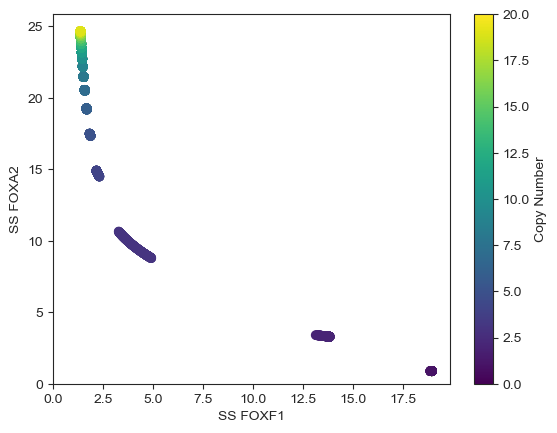

In [61]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots()
for k in range(z1xarray.shape[2]):
    #Splt.scatter(z1xarray[:,:,k], z2yarray[:,:,k], label = f'alpha = {a_array[k]}')
    a = plt.scatter(z1xarray[:,:,k], z2yarray[:,:,k], c=a_array[k]*np.ones(len(z1xarray[:,:,k]) ** 2), cmap='viridis', vmin=0, vmax=20)
fig.colorbar(a, label='Copy Number')
axs.set_xlim(0)
axs.set_ylim(0)
axs.set_xlabel('SS FOXF1')
axs.set_ylabel('SS FOXA2')
#plt.legend()

Z1 = 13.746858618233796
Z1 = 1.4902647693181712
Z1 = 1.39296830682775
Z2 = 3.3064173812058146
Z2 = 22.22236636868333
Z2 = 24.34237094919903


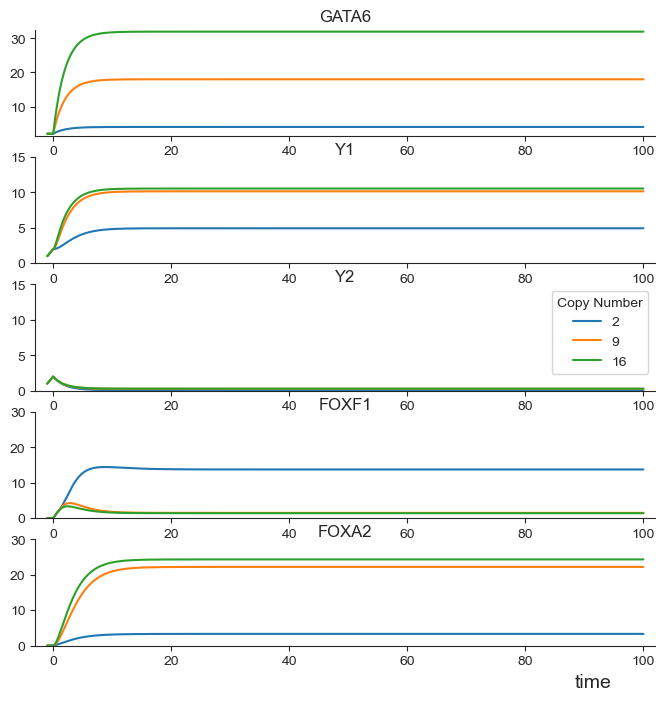

In [60]:

import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
import seaborn as sns
"""
The same thing as above but with 2 nested FFLs instead.
"""

def hill_act(X, K, n):
    return X**n / (K**n + X**n)

def hill_inh(X, K, n):
    return K**n / (K**n + X**n)

def rhs(xyz, t, a, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    x, y1, y2, z1, z2 = xyz

    dx_dt = a - b * x
    dy1_dt = c * hill_act(x, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(x, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(x, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(x, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)

    return np.array([dx_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt])

sns.set_style('ticks')
%matplotlib inline

# Time points we want for the solution
t = np.linspace(0, 100, 1000)

# Initial condition
xyz_0 = np.array([2.0, 2.0, 2.0, 0.0, 0.0])

# Parameters
Fs = [2, 9, 16]
# b, c, d, e, f, g, h, i, j, k, l = [0.5, 10.0, optimized_params[0], 10.0, optimized_params[1], 10.0, 
#                                    10.0, optimized_params[2], 10.0, 10.0, optimized_params[3]]
# nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2, 2, 2, 2, 2, 2, 2, 2, 2]
# KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = [10.0, 10.0, 10.0, optimized_params[8], optimized_params[6], 
#                                                                 optimized_params[4], 10.0, optimized_params[9], 
#                                                                 optimized_params[7], optimized_params[5]]
b, c, d, e, f, g, h, i, j, k, l = optimized_params[:11]
KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = optimized_params[11:]
nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2]*9


# Keeping Track of the final values:
xs = []
y1s = []
y2s = []
z1s = []
z2s = []

for F in Fs:
    # Integrate ODES
    xyz = integrate.odeint(rhs, xyz_0, t, args=(F, b, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, 
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y))
    # Pluck out y and z
    x, y1, y2, z1, z2 = xyz.transpose()

    # Append the pre-fold change steady state
    x = np.insert(x, 0, 2.0)
    y1 = np.insert(y1, 0, 1.0)
    y2 = np.insert(y2, 0, 1.0)
    z1 = np.insert(z1, 0, 0.0)
    z2 = np.insert(z2, 0, 0.0)
    xs.append(x)
    y1s.append(y1)
    y2s.append(y2)
    z1s.append(z1)
    z2s.append(z2)
t = np.insert(t, 0, -1.0)

# Generate x
#x = 2.0 + 2.0 * (t > 0.0).astype(dtype=float)
# Plot the results
fig, ax = plt.subplots(5, 1, figsize=(8, 8))
for y in y1s:
    ax[1].set_title('Y1', pad=-100)
    ax[1].plot(t, y, '-')
    ax[1].set_ylim([0, 15])
for y in y2s:
    ax[2].set_title('Y2', pad=-100)
    ax[2].plot(t, y, '-')
    ax[2].set_ylim([0, 15])
for x in xs:
    ax[0].set_title('GATA6')
    ax[0].plot(t, x, '-')
for z1 in z1s:
    ax[3].set_title('FOXF1', pad=-100)
    ax[3].plot(t, z1, '-')
    print(f'Z1 = {z1[-1]}')
    ax[3].set_ylim([0, 30])
for z2 in z2s:
    ax[4].set_title('FOXA2',pad=-100)
    ax[4].plot(t, z2, '-')
    print(f'Z2 = {z2[-1]}')
    ax[4].set_ylim([0, 30])
for i in range(ax.size):
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])
    ax[i].margins(0.02)
    ax[i].set_xlabel('time', x=.9, fontsize=14)

    ax[i].yaxis.set_label_coords(-0.05, 0.9) 
ax[2].legend(Fs, title='Copy Number')
sns.despine(offset=0.1)

In [85]:
optimized_params = np.array([5.37352557, 0.5,        0.15164532, 0.5,        3.41323608,
 8.08063479, 0.5,        8.07576539, 5.52822741, 0.5,        4.33834965,
 7.0079098,  5.77644675, 5.86557976, 1.17319128, 5.2299828,  9.7703752,
 8.80489012, 8.41532703, 4.81912212])


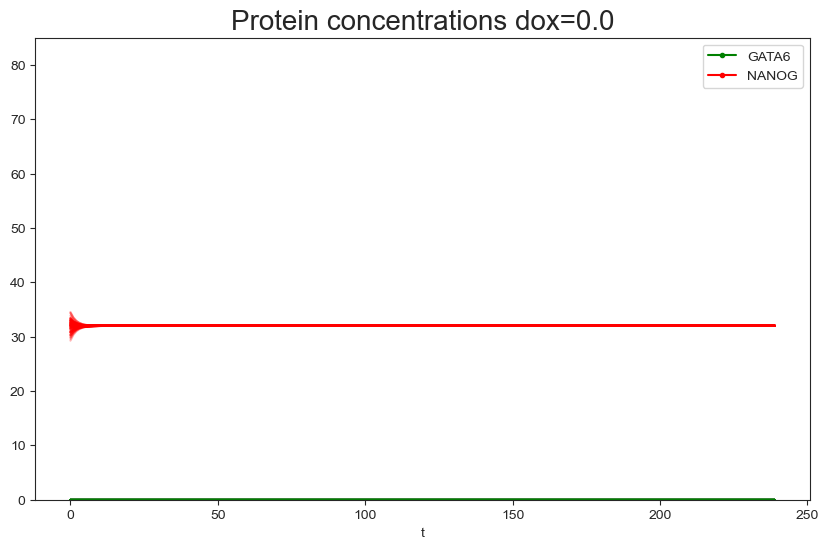

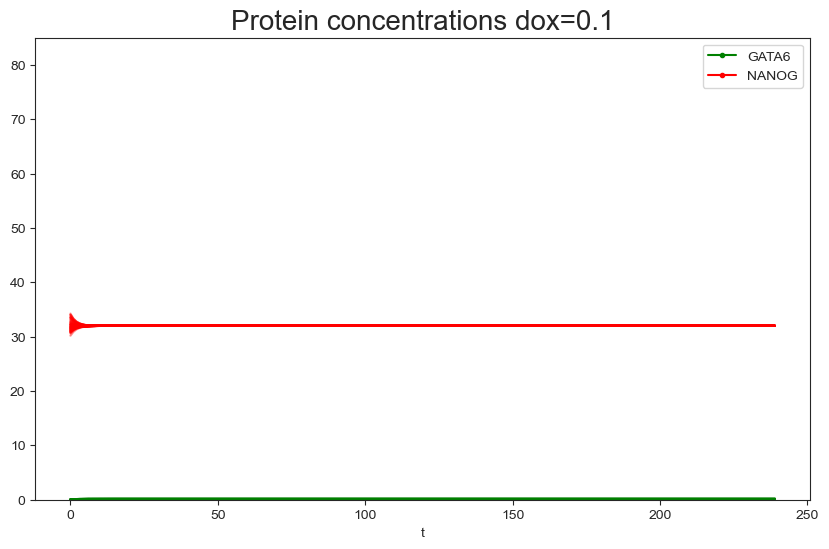

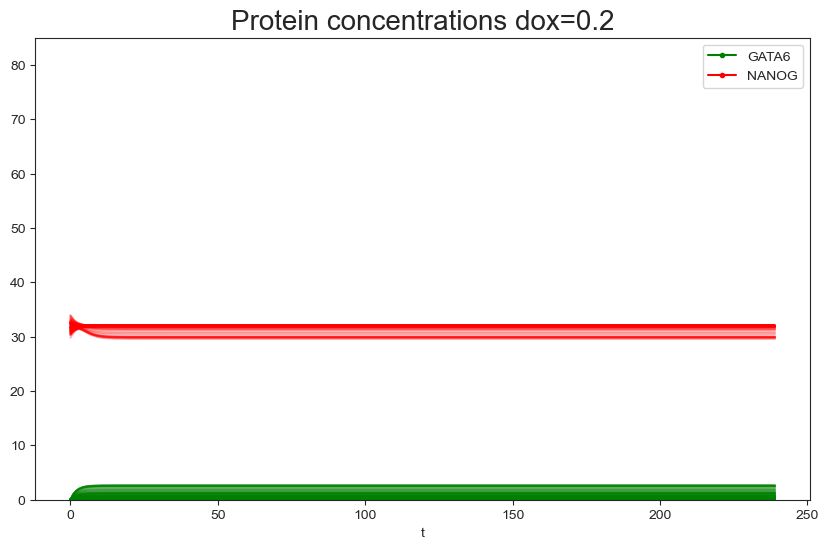

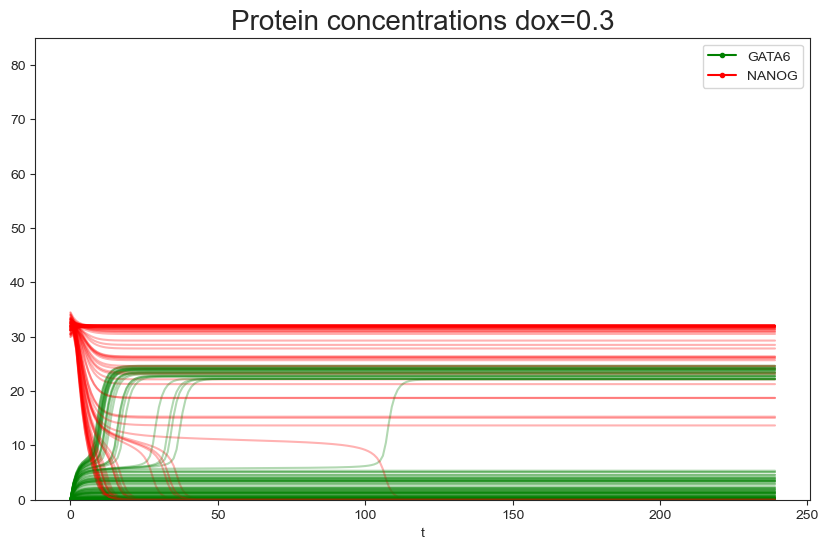

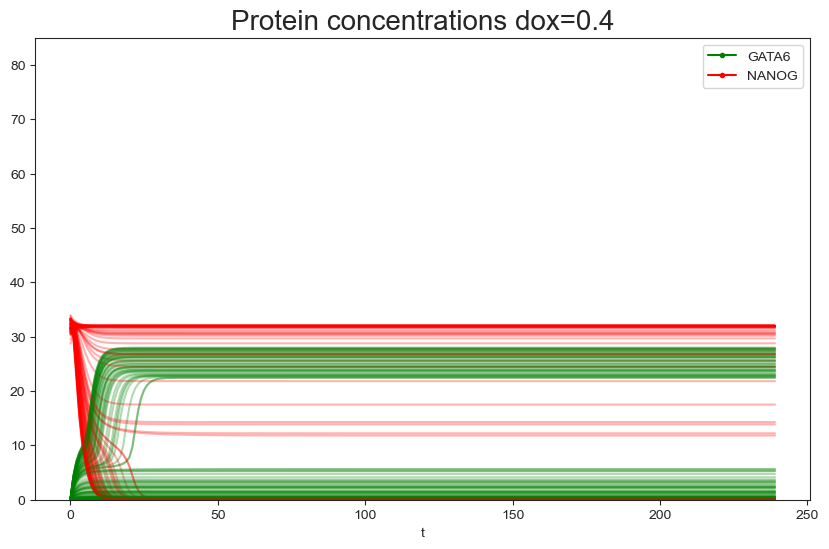

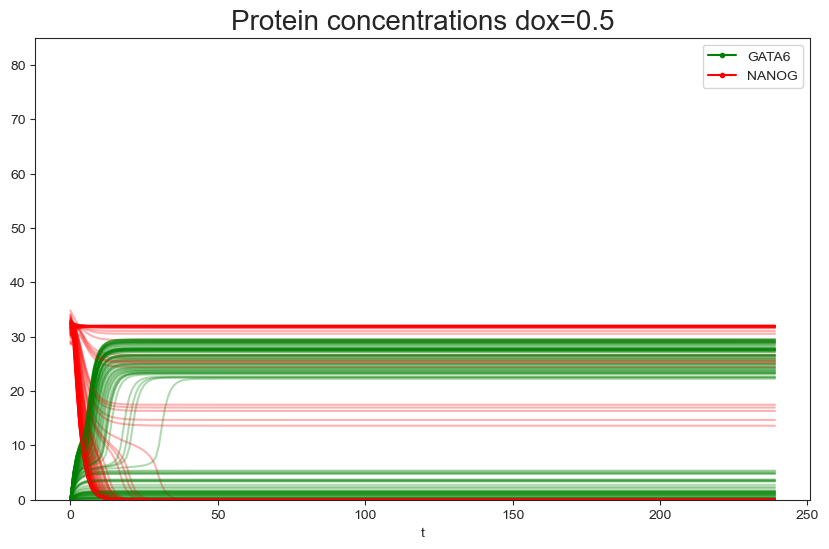

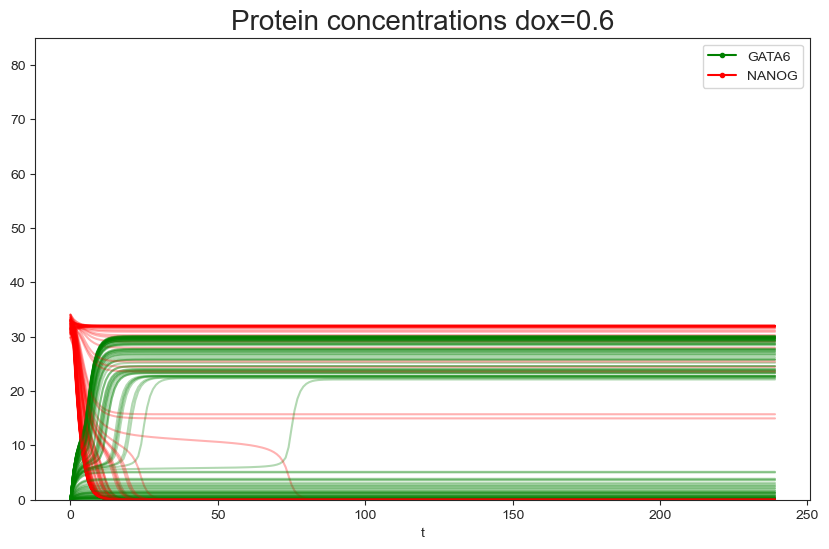

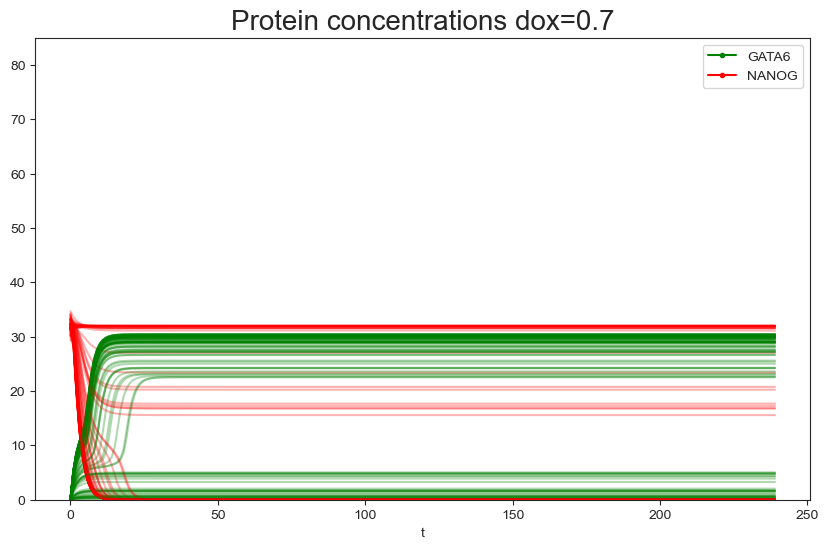

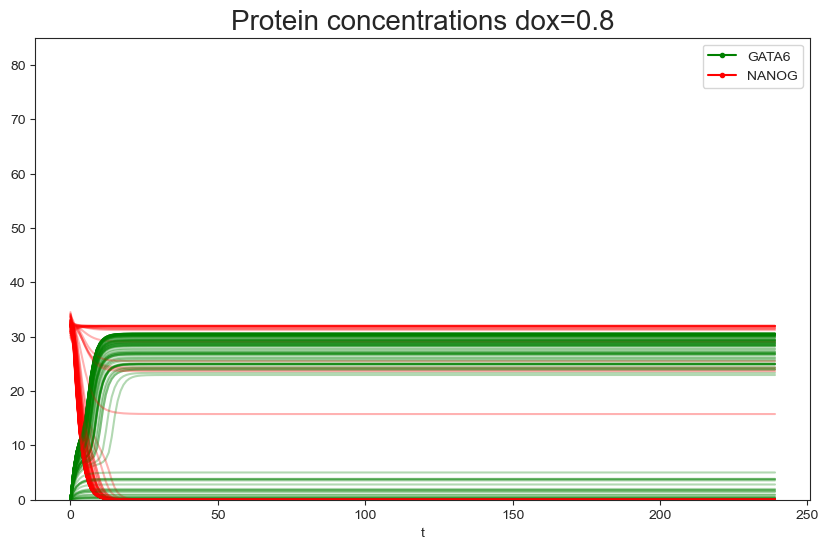

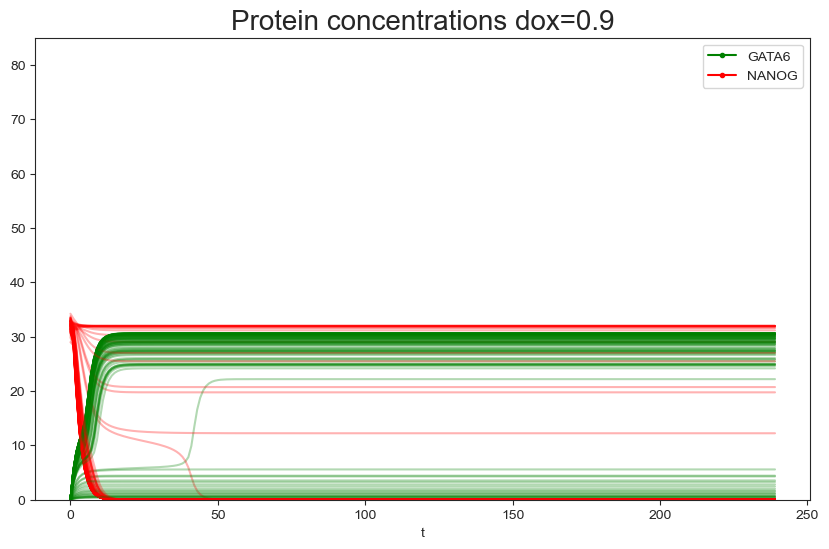

In [72]:
dox = np.arange(0, 1, 0.1)
for j in range(len(list_GATA6)):
    GATA6 = list_GATA6[j]
    NANOG = list_NANOG[j]
    FOXA2 = list_FOXA2[j]
    FOXF1 = list_FOXF1[j]
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    for i in range(num_cells):
        ax.plot(t, GATA6[i,:], color='g', alpha=0.3)
        ax.plot(t, NANOG[i,:], color ='r', alpha=0.3)
        # ax.plot(t, FOXA2[i,:], color='b', alpha=0.3)
        # ax.plot(t, FOXF1[i,:], color ='k', alpha=0.3)
    ax.set_title(f'Protein concentrations dox={dox[j]:.1f}', fontsize=20)
    ax.set_ylim([0, 85])
    ax.set_xlabel('t')
    plt.legend(['GATA6','NANOG'], handler_map={plt.Line2D: HandlerLine2D(update_func=change_alpha)})

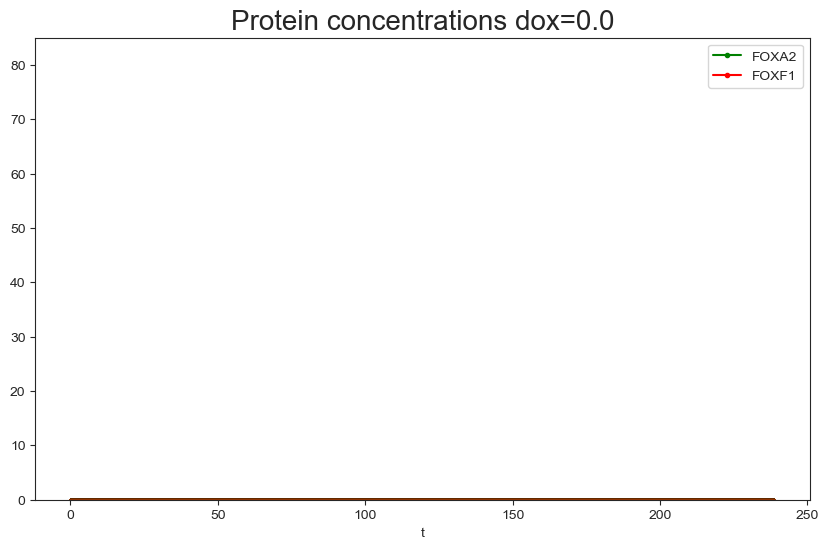

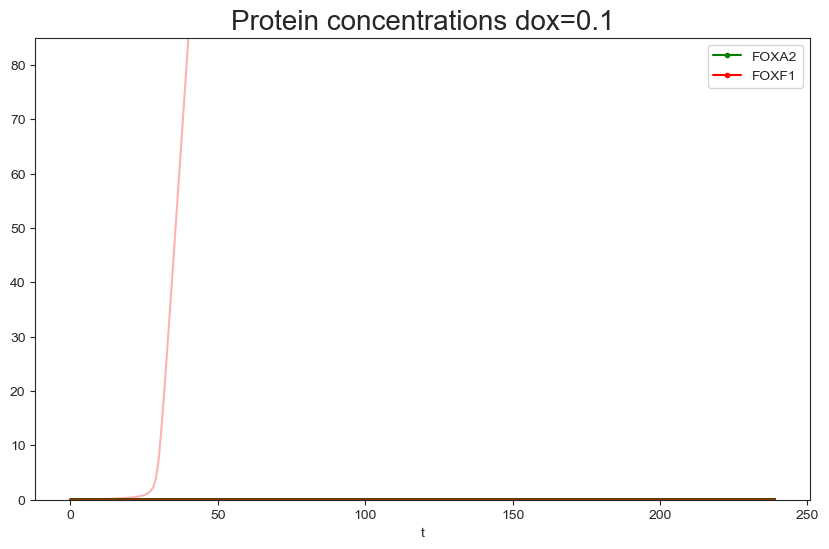

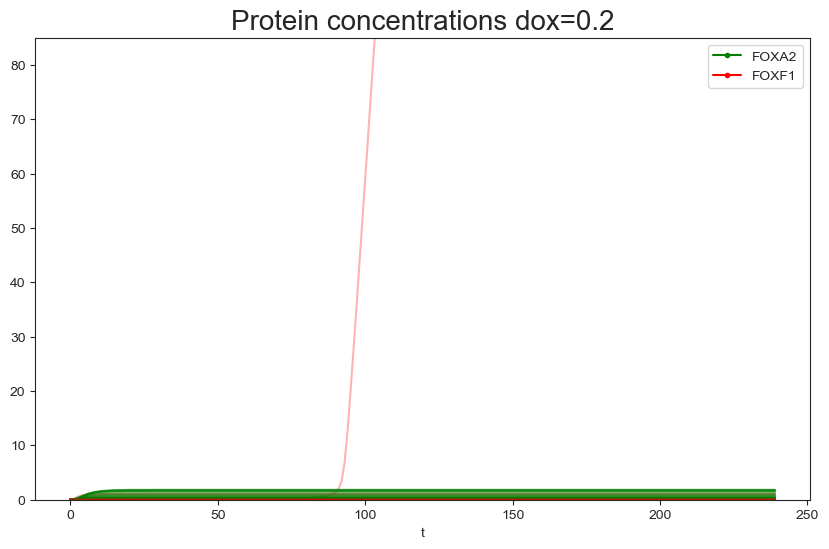

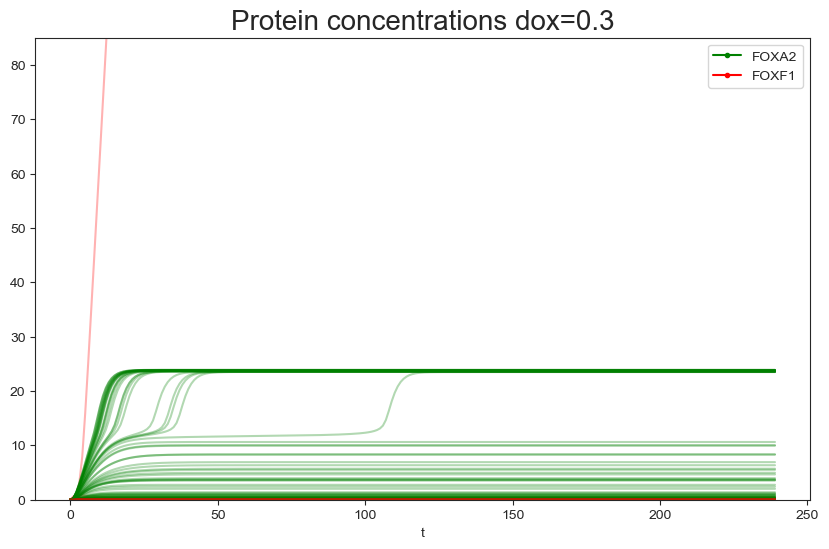

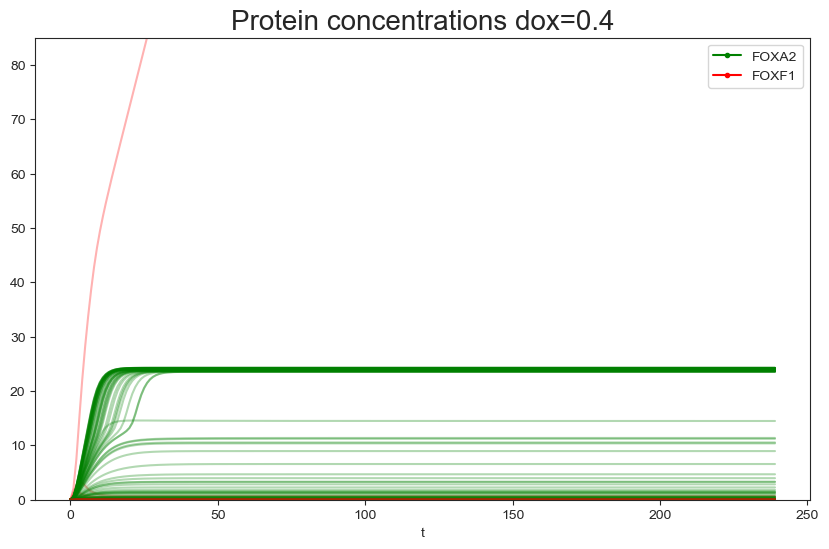

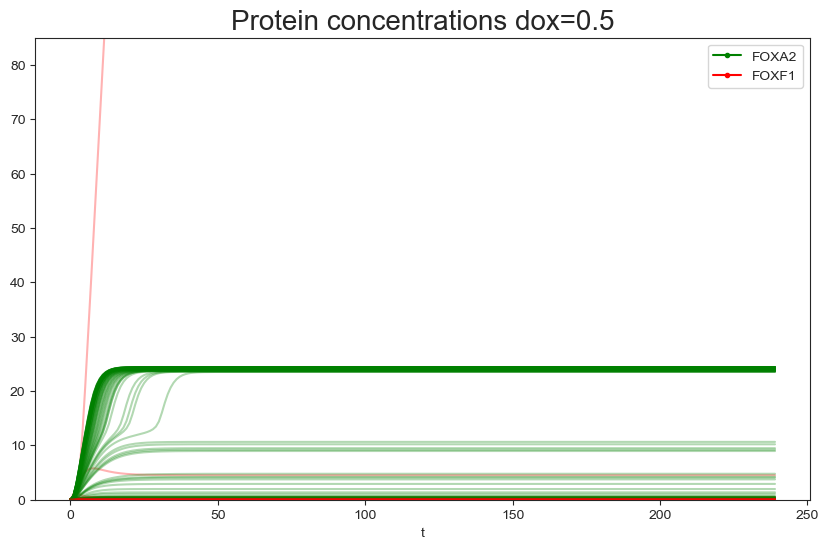

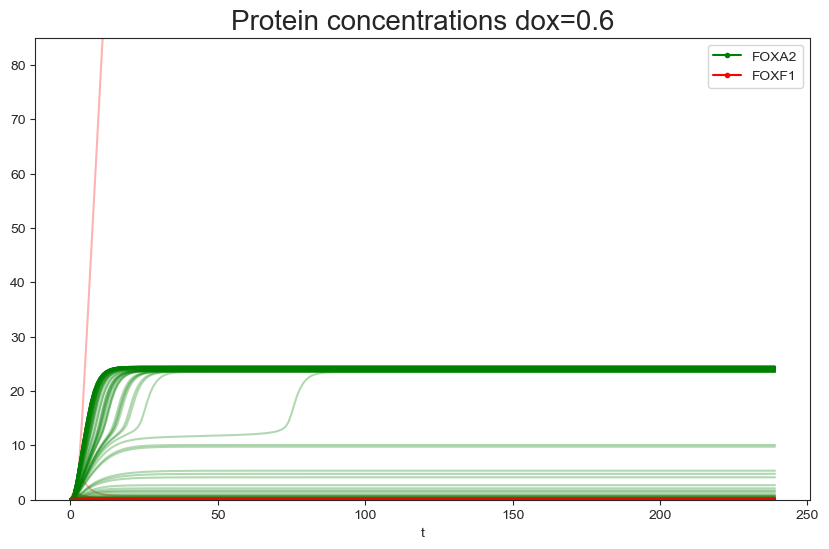

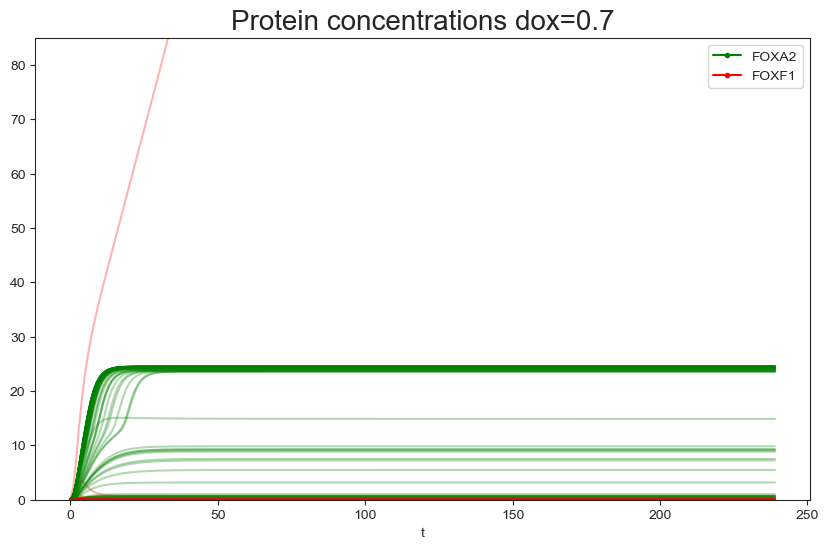

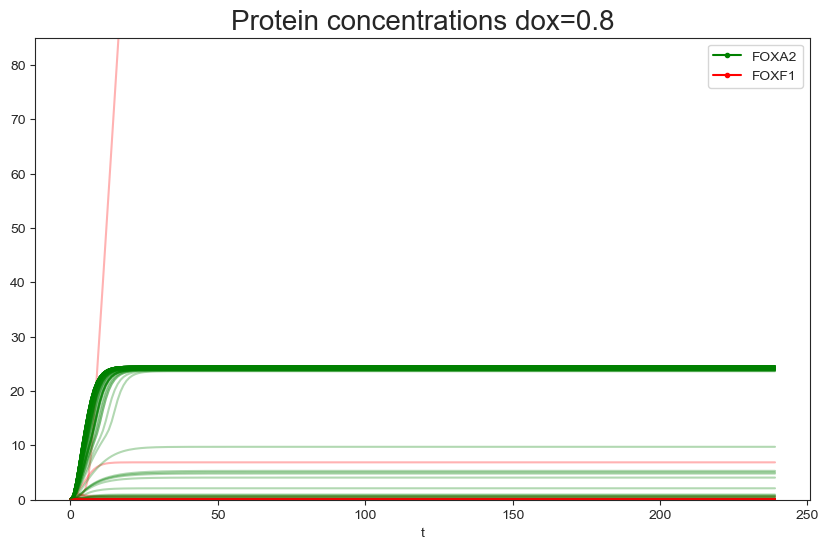

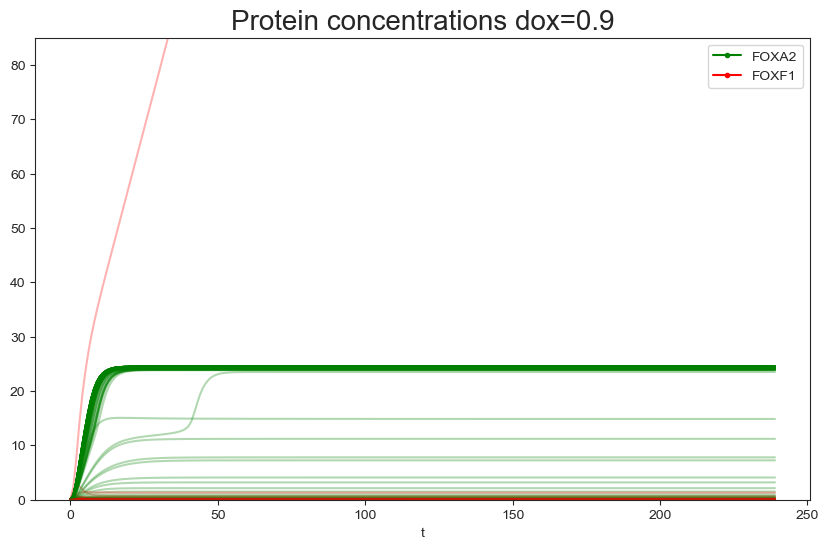

In [70]:
dox = np.arange(0, 1, 0.1)
for j in range(len(list_GATA6)):
    FOXA2 = list_FOXA2[j]
    FOXF1 = list_FOXF1[j]
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    for i in range(num_cells):
        ax.plot(t, FOXA2[i,:], color='g', alpha=0.3)
        ax.plot(t, FOXF1[i,:], color ='r', alpha=0.3)
    ax.set_title(f'Protein concentrations dox={dox[j]:.1f}', fontsize=20)
    ax.set_ylim([0, 85])
    ax.set_xlabel('t')
    plt.legend(['FOXA2', 'FOXF1'], handler_map={plt.Line2D: HandlerLine2D(update_func=change_alpha)})

In [79]:
# Target function to minimize
import numpy as np
import scipy.optimize as optimize
from scipy.integrate import odeint
import time


def hill_act(X, K, n):
    return X**n / (K**n + X**n)

def hill_inh(X, K, n):
    return K**n / (K**n + X**n)

def dnanog(NANOG, GATA6, a1, a2, a3, n, m, KM_NN, KM_GN):
    return (a1 * NANOG ** n)/(KM_NN ** n + NANOG ** n) * (a2 * KM_GN ** m)/(KM_GN ** m + GATA6 ** m) - a3 * NANOG

def dgata6(NANOG, GATA6, dox, p, a1, a2, a3, n, m, KM_GG, KM_NG):
    return dox * p + (a1 * GATA6 ** n)/(KM_GG ** n + GATA6 ** n) * (a2 * KM_NG ** m)/(KM_NG ** m + NANOG ** m) - a3 * GATA6

def dudt(U, t, dox, p):
    NANOG, GATA6 = U
    a1 = 4
    b1 = 4
    a2 = 4
    b2 = 4
    a3 = 0.5
    b3 = 0.5
    KM_NN, KM_GN, KM_GG, KM_NG = [5, 5, 5, 5]
    n = m = 4

    d = 0
    if t > 12:
        d = dox
    dnanog_dt = dnanog_rna(NANOG, GATA6, a1, a2, a3, n, m, KM_NN, KM_GN)
    dgata6_dt = dgata6_rna(NANOG, GATA6, d, p, b1, b2, b3, n, m, KM_GG, KM_NG)
    return dnanog_dt, dgata6_dt

def rhs(xyz, t, dox, p, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    
    nanog, gata6, y1, y2, z1, z2 = xyz

    a1 = 4
    b1 = 4
    a2 = 4
    b2 = 4
    a3 = 0.5
    b3 = 0.5
    KM_NN, KM_GN, KM_GG, KM_NG = [5, 5, 5, 5]
    n = m = 4

    dnanog_dt = dnanog(nanog, gata6, a1, a2, a3, n, m, KM_NN, KM_GN)
    dgata6_dt = dgata6(nanog, gata6, dox, p, b1, b2, b3, n, m, KM_GG, KM_NG)
    dy1_dt = c * hill_act(gata6, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(gata6, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(gata6, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(gata6, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)

    return dnanog_dt, dgata6_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt

def ode(params):
    dox = 0.9   #experiment condition
    copy_number = np.arange(1, 16, 1)  #copy number variation
    tf = 100
    t = np.linspace(0, tf, 1)
    obj = 0
    c, d, e, f, g, h, i, j, k, l = params[:10]
    KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = params[10:]
    # We don't necessarily have to adjust these.
    nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2]*9

    for value in copy_number:
        # initial conditions
        nanog_initial = np.random.normal(32)
        gata6_initial = np.random.rand() * 0.15

        initial_conditions = [nanog_initial, gata6_initial, 0, 0, 0, 0]  # Adjust initial conditions as needed, try system starts at 0s
        # Solve ODEs
        solution = odeint(rhs, initial_conditions, t, args=(dox, value, c, d, e, f, g, h, i, j,
                                                    k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
                                                    KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, 
                                                    n1y, n22, n21, n2x, n2y))

        # Calculate the objective values based on steady states of z1 and z2
        ssZ1 = solution[-1, 4]
        ssZ2 = solution[-1, 5]

        # Minimize negative objectives to achieve the desired behavior
        # fix these objective/cost functions to actually match what we're looking for
        values = odeint(dudt, [nanog_initial, gata6_initial], t, args=(dox, value))

        ssNN = values[-1,0]
        ssG6 = values[-1,1]

        obj += np.sqrt((ssNN-ssZ1)**2 + (ssG6-ssZ2) ** 2)
    return obj

# Initial guess for parameters
# Use symmetrical system for initial parameters
degradation_rates = [1,3,6,9]
production_rates = [0,2,4,5,7,8]
production_rates_2 = [4, 5]

initial_params = 20 * np.random.rand(20)
initial_params[degradation_rates] = np.ones(len(degradation_rates)) * 1
initial_params[production_rates] = np.ones(len(production_rates)) * 1

param_bounds = np.array([(0, 20)] * 20)
param_bounds[degradation_rates] = (1e-6, 1)
param_bounds[production_rates] = (0, 10)


# Perform optimization
start_time = time.time()
#result = optimize.minimize(ode, initial_params, bounds=param_bounds, method='Powell')
result = optimize.differential_evolution(ode, bounds=param_bounds, init='halton')

optimized_params = result.x
print("Optimized parameters:", optimized_params)
success = ['unsuccessful', 'successful']
print(f'Optimization was {success[result.success]} and took {time.time()-start_time} seconds')

Optimized parameters: [ 7.62830695  0.75074291  5.29994741  0.66395905  5.90313228  8.79499063
  0.24235223  1.69234706  2.23876325  0.14750336 15.91095748  9.9430415
 16.6817259  12.30883598  7.19517848 13.15624339  7.25318592 10.33715548
  1.19203695 12.81473462]
Optimization was successful and took 0.5060338973999023 seconds


In [69]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerLine2D


'''
NANOG-GATA6 MODEL with separated protein and rna
We observe few differences in dgata6 due to the dominating hill-like equation in the system
'''

def change_alpha(handle, original):
    ''' Change the alpha and marker style of the legend handles '''
    handle.update_from(original)
    handle.set_alpha(1)
    handle.set_marker('.')

def hill_act(X, K, n):
    return X**n / (K**n + X**n)

def hill_inh(X, K, n):
    return K**n / (K**n + X**n)

def dnanog(NANOG, GATA6, a1, a2, a3, n, m, KM_NN, KM_GN):
    return a1 * hill_act(NANOG, KM_NN, n) * a2 * hill_inh(GATA6, KM_GN, m) - a3 * NANOG

def dgata6(NANOG, GATA6, dox, p, a0, a1, a2, a3, n, m, o, KM_GG, KM_NG, KM_dox):
    return a0 * hill_act(dox*p, KM_dox, o) + a1 * hill_act(GATA6, KM_GG, n) * a2 * hill_inh(NANOG, KM_NG, m) - a3 * GATA6

def rhs(xyz, t, dox, p, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    
    nanog, gata6, y1, y2, z1, z2 = xyz

    b0 = 7
    a1 = 4
    b1 = 2.1
    a2 = 4
    b2 = 4
    a3 = 0.5
    b3 = 0.5
    KM_NN, KM_GN, KM_GG, KM_NG, KM_dox = [5, 5, 5, 5, 4.5]
    n = m = 4

    dox_induction = 12
    if t > 0:
        dox_induction = dox
    dnanog_dt = a1 * hill_act(nanog, KM_NN, n) * a2 * hill_inh(gata6, KM_GN, m) - a3 * nanog
    dgata6_dt = b0 * hill_act(dox_induction*p, KM_dox, n) + b1 * hill_act(gata6, KM_GG, n) * b2 * hill_inh(nanog, KM_NG, m) - b3 * gata6
    dy1_dt = c * hill_act(gata6, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(gata6, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(gata6, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(gata6, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)

    return dnanog_dt, dgata6_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt

dox = np.arange(0, 1, 0.1)
list_GATA6 = []
list_NANOG = []
list_FOXA2 = []
list_FOXF1 = []
list_Y1 = []
list_Y2 = []

optimized_params = np.array([5.37352557, 0.5,        0.15164532, 0.5,        3.41323608,
 8.08063479, 0.5,        8.07576539, 5.52822741, 0.5,        4.33834965,
 7.0079098,  5.77644675, 6.86557976, 1.17319128, 5.2299828,  9.7703752,
 8.80489012, 8.41532703, 4.81912212])


c, d, e, f, g, h, i, j, k, l = optimized_params[:10]
KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = optimized_params[10:]
nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2]*9

tf = 240
#dox = [0]
for value in dox:
    num_cells = 100
    t = np.arange(0, tf, 1)
    

    GATA6 = np.zeros((num_cells, len(t)))
    NANOG = np.zeros((num_cells, len(t)))
    FOXA2 = np.zeros((num_cells, len(t)))
    FOXF1 = np.zeros((num_cells, len(t)))
    Y1 = np.zeros((num_cells, len(t)))
    Y2 = np.zeros((num_cells, len(t)))
    
    for i in range(num_cells):
        p = np.random.uniform(2, 16)
        nanog_initial = np.random.normal(32)
        gata6_initial = 0
        y1_initial = 2
        y2_initial = 2
        FOXA2_initial = 0
        FOXF1_initial = 0
        U = [nanog_initial, gata6_initial, y1_initial, y2_initial, FOXF1_initial, FOXA2_initial]
        values = integrate.odeint(rhs, U, t, args=(value, p, c, d, e, f, g, h, i, j,
                                                    k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
                                                    KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, 
                                                    n1y, n22, n21, n2x, n2y))
        NANOG[i,:], GATA6[i,:], Y1[i,:], Y2[i,:], FOXF1[i,:], FOXA2[i,:] = values[:,0], values[:,1], values[:,2], values[:,3], values[:,4], values[:,5]
    
    list_GATA6.append(GATA6)
    list_NANOG.append(NANOG)
    list_FOXA2.append(FOXA2)
    list_FOXF1.append(FOXF1)
    list_Y2.append(Y2)
    list_Y1.append(Y1)


Text(0.5, 1.0, 'Steady State FOXF1 Values')

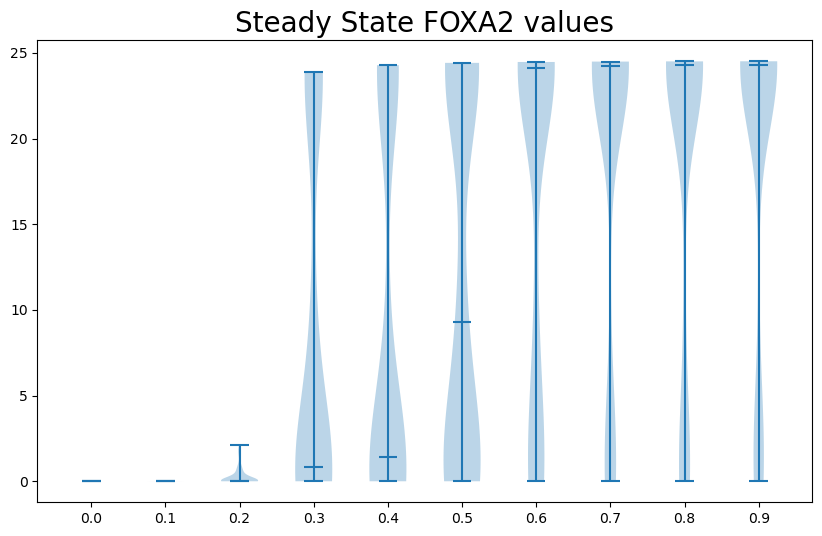

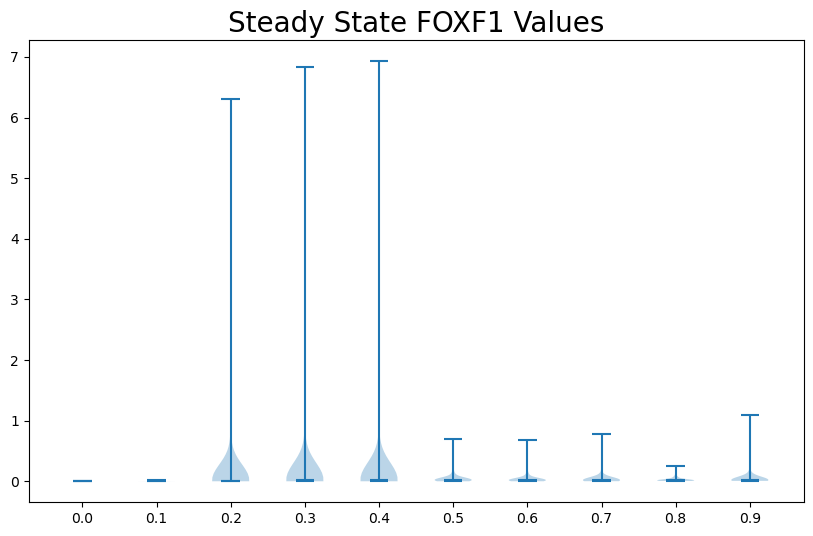

In [45]:
dox = np.arange(0, 1, 0.1)
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
#kwargs = dict(lw=0, alpha=0.5, bins=50, histtype='bar', stacked=True, range=[2,3])
ss_foxa2 = []
ss_y2 = []

def write_legend(values):
    return ["{0:.1f}".format(value) for value in values]

for FOXA2 in list_FOXA2:
    ss_foxa2.append(FOXA2[:,-1])
for Y2 in list_Y2:
    ss_y2.append(Y2[:,-1])
ax.violinplot(ss_foxa2, showmeans=False,showmedians=True)
plt.xticks([y + 1 for y in range(len(ss_foxa2))], labels=write_legend(dox))
ax.set_title(f'Steady State FOXA2 values', fontsize=20)


fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
#kwargs = dict(lw=0, alpha=0.5, bins=50, histtype='bar', stacked=True, range=[2,3])
ss_foxf1 = []
ss_y1 = []
for FOXF1 in list_FOXF1:
    ss_foxf1.append(np.sort(FOXF1[:,-1])[:-1])
for Y1 in list_Y1:
    ss_y1.append(Y1[:,-1])
ax.violinplot(ss_foxf1, showmeans=False,showmedians=True)
plt.xticks([y + 1 for y in range(len(ss_foxf1))], labels=write_legend(dox))
ax.set_title(f'Steady State FOXF1 Values', fontsize=20)

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

optimized_params = np.array([5.37352557, 0.5,        0.15164532, 0.5,        3.41323608,
 8.08063479, 0.5,        8.07576539, 5.52822741, 0.5,        4.33834965,
 7.0079098,  5.77644675, 5.86557976, 1.17319128, 5.2299828,  9.7703752,
 8.80489012, 8.41532703, 4.81912212])


def calc(a, params, z1_0, z2_0):
    # Time points we want for the solution
    t = np.linspace(0, 30, 100)


    # Initial condition
    nanog_initial = np.random.normal(32)
    gata6_initial = 0
    y1_initial = 2
    y2_initial = 2
    FOXA2_initial = z1_0
    FOXF1_initial = z2_0
    U = [nanog_initial, gata6_initial, y1_initial, y2_initial, FOXF1_initial, FOXA2_initial]

    # Parameters
    c, d, e, f, g, h, i, j, k, l = optimized_params[:10]
    KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = optimized_params[10:]
    nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2]*9
    
#     b, c, d, e, f, g, h, i, j, k, l = [0.5, 10.0, optimized_params[0], 10.0, optimized_params[1], 10.0, 
#                                        10.0, optimized_params[2], 10.0, 10.0, optimized_params[3]]
#     nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y = [2, 2, 2, 2, 2, 2, 2, 2, 2]
#     KMxy1, KMxy2, KM11, KM12, KM1x, KM1y, KM22, KM21, KM2x, KM2y = [10.0, 10.0, 10.0, optimized_params[8], optimized_params[6], 
#                                                                     optimized_params[4], 10.0, optimized_params[9], 
#                                                                     optimized_params[7], optimized_params[5]]

    # Integrate ODES
    xyz = integrate.odeint(rhs, U, t, args=(0.4, a, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y))
    nanog, x, y1, y2, z1, z2 = xyz.transpose()
    return z1[-1], z2[-1]

def hill_act(X, K, n):
    return X**n / (K**n + X**n)

def hill_inh(X, K, n):
    return K**n / (K**n + X**n)


def rhs(xyz, t, dox, p, c, d, e, f, g, h, i, j, k, l, KMxy1, KMxy2, KM11, KM12, KM1x, KM1y,
        KM22, KM21, KM2x, KM2y, nx, n11, n12, n1x, n1y, n22, n21, n2x, n2y):
    
    nanog, gata6, y1, y2, z1, z2 = xyz

    b0 = 7
    a1 = 4
    b1 = 2.1
    a2 = 4
    b2 = 4
    a3 = 0.5
    b3 = 0.5
    KM_NN, KM_GN, KM_GG, KM_NG, KM_dox = [5, 5, 5, 5, 4.5]
    n = m = 4

    dox_induction = 0
    if t > 0:
        dox_induction = dox
    dnanog_dt = a1 * hill_act(nanog, KM_NN, n) * a2 * hill_inh(gata6, KM_GN, m) - a3 * nanog
    dgata6_dt = b0 * hill_act(dox_induction*p, KM_dox, n) + b1 * hill_act(gata6, KM_GG, n) * b2 * hill_inh(nanog, KM_NG, m) - b3 * gata6
    dy1_dt = c * hill_act(gata6, KMxy1, nx) - d * y1
    dy2_dt = e * hill_act(gata6, KMxy2, nx) - f * y2
    dz1_dt = g * hill_act(gata6, KM1x, n1x) * hill_inh(y1, KM1y, n1y) - i * z1 + h * hill_act(z1, KM11, n11) * hill_inh(z2, KM12, n12)
    dz2_dt = j * hill_act(gata6, KM2x, n2x) * hill_inh(y2, KM2y, n2y) - l * z2 + k * hill_act(z2, KM22, n22) * hill_inh(z1, KM21, n21)

    return dnanog_dt, dgata6_dt, dy1_dt, dy2_dt, dz1_dt, dz2_dt


y1array=np.arange(0,20,1)
y2array=np.arange(0,20,1)
a_array = np.arange(1, 20, 1)
z1xarray=np.empty((len(y2array),len(y1array), len(a_array)))
z2yarray=np.empty((len(y2array),len(y1array), len(a_array)))

for k,alpha in enumerate(a_array):
    for i,R1 in enumerate(y1array):
        for j,R2 in enumerate(y2array):
            values = calc(a=alpha,params = optimized_params, z1_0=R1, z2_0=R2)
            z1xarray[j,i,k]=values[0]
            z2yarray[j,i,k]=values[1]

Text(0, 0.5, 'SS FOXA2')

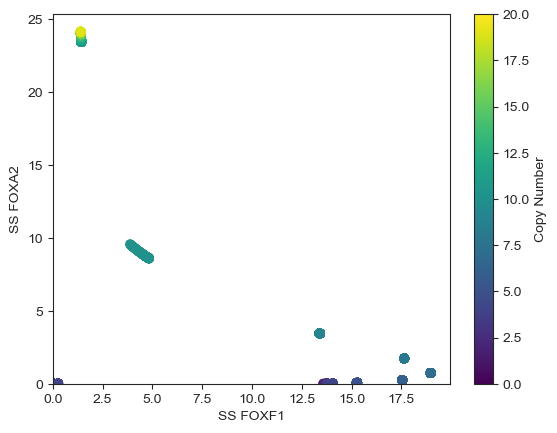

In [67]:
fig, axs = plt.subplots()
for k in range(z1xarray.shape[2]):
    #Splt.scatter(z1xarray[:,:,k], z2yarray[:,:,k], label = f'alpha = {a_array[k]}')
    a = plt.scatter(z1xarray[:,:,k], z2yarray[:,:,k], c=a_array[k]*np.ones(len(z1xarray[:,:,k]) ** 2), cmap='viridis', vmin=0, vmax=20)

fig.colorbar(a, label='Copy Number')
axs.set_xlim(0)
axs.set_ylim(0)
axs.set_xlabel('SS FOXF1')
axs.set_ylabel('SS FOXA2')